# MCMC Alt Approach

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import gpflow

from gpflow import default_float
from gpflow.ci_utils import ci_niter

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-4)
gpflow.config.set_default_summary_fmt("notebook")
# convert to float64 for tfp to play nicely with gpflow in 64
f64 = gpflow.utilities.to_default_float

f64 = gpflow.utilities.to_default_float

In [176]:
def f(x):
    return 0.2 * np.sqrt(x) + np.sin(x/10)

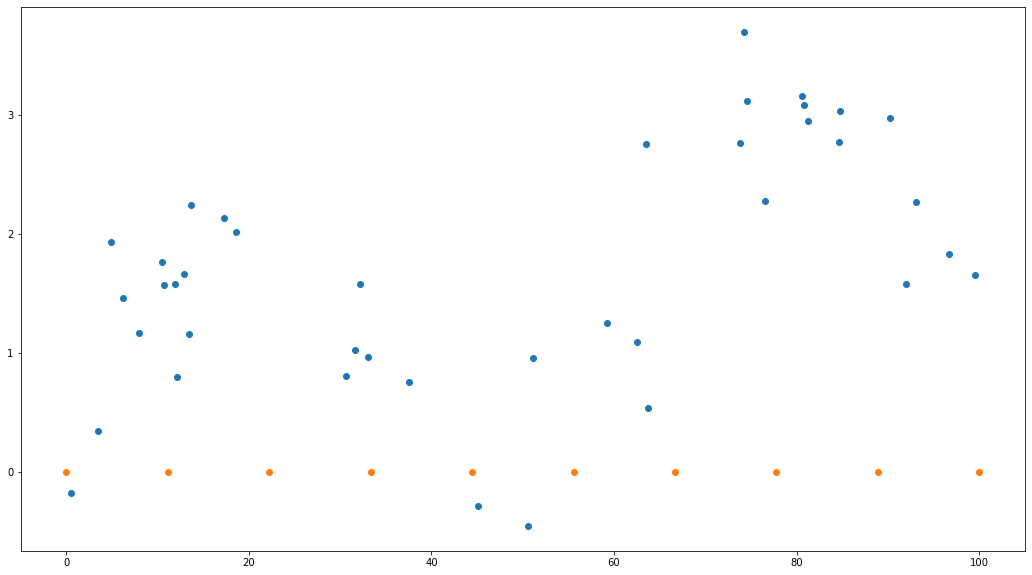

In [201]:
obs_noise = 0.5
num_points = 40
inducing = 10
Xrange = (0, 100)

X = np.random.uniform(Xrange[0], Xrange[1], (num_points, 1))
Z = np.linspace(Xrange[0], Xrange[1], inducing)[:, None]
Y = f(X) + np.random.normal(0., obs_noise, (num_points, 1))
Xtest = np.linspace(np.min(X), np.max(X), 200)[:, None]


plt.figure(figsize=(18, 10))
plt.scatter(X, Y)
plt.scatter(Z, [0 for i in Z])

data = (X, Y)

In [202]:
kernel = gpflow.kernels.Matern52()
likelihood = gpflow.likelihoods.Gaussian()
model = gpflow.models.SGPMC(data, kernel, likelihood, inducing_variable = Z)
model = gpflow.models.SGPR(data, kernel, inducing_variable = Z, noise_variance = 0.1)

In [203]:
model.kernel.lengthscales.assign(5.0)
model.kernel.variance.assign(5.0)

model.kernel.lengthscales.prior = tfd.Gamma(f64(0.5), f64(0.5))
model.kernel.variance.prior = tfd.Gamma(f64(0.5), f64(0.5))
model.likelihood.variance.prior = tfd.Gamma(f64(0.1), f64(0.1))

optimiser = gpflow.optimizers.Scipy()
maxiter = ci_niter(2000)
_ = optimiser.minimize(
    model.training_loss, model.trainable_variables, options=dict(maxiter=maxiter)
)

gpflow.utilities.set_trainable(model.inducing_variable.Z, False)

In [204]:
f_samples_map = model.predict_f_samples(Xtest, 25000)

In [205]:
@tf.function
def run_chain_fn(model, num_samples, num_burnin_steps, num_leapfrog_steps = 5, step_size = 0.2):
    num_samples = ci_niter(num_samples)
    num_burnin_steps = ci_niter(num_burnin_steps)
    
    hmc_helper = gpflow.optimizers.SamplingHelper(
        model.log_posterior_density, model.trainable_parameters
    )
    hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=hmc_helper.target_log_prob_fn, num_leapfrog_steps=3, step_size=0.2
    )
    adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
        hmc, num_adaptation_steps=1000, target_accept_prob=f64(0.9), adaptation_rate=0.02
    )
    
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        num_steps_between_results = 5,
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
    )

samples, _ = run_chain_fn(model, num_samples, num_burnin_steps)
parameter_samples = hmc_helper.convert_to_constrained_values(samples)

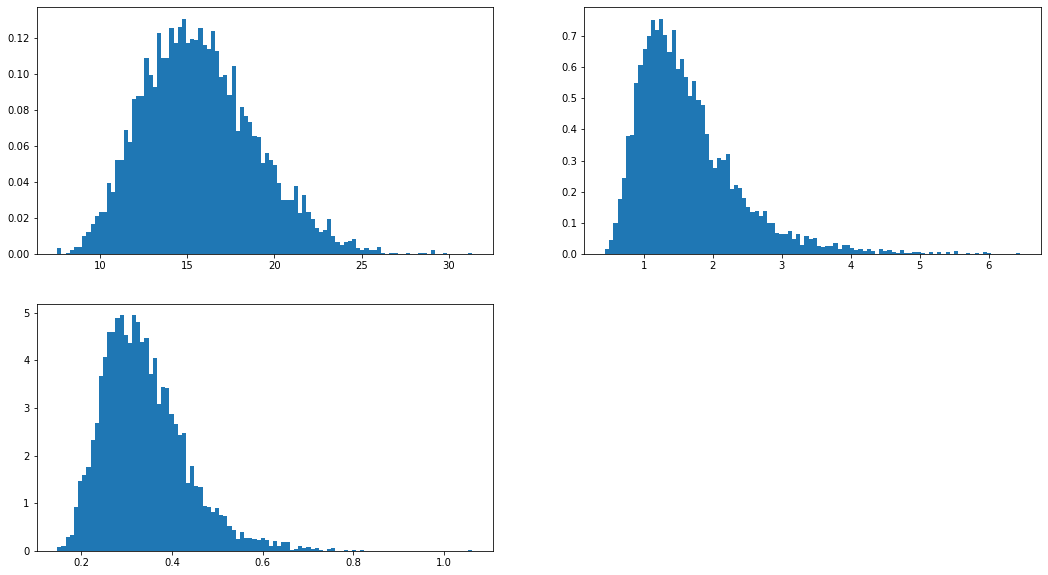

In [206]:
plt.figure(figsize = (18, 10))
plt.subplot(221)
plt.hist(parameter_samples[0].numpy(), 100, density=True)
plt.subplot(222)
plt.hist(parameter_samples[1].numpy(), 100, density=True)
plt.subplot(223)
plt.hist(parameter_samples[2].numpy(), 100, density=True);

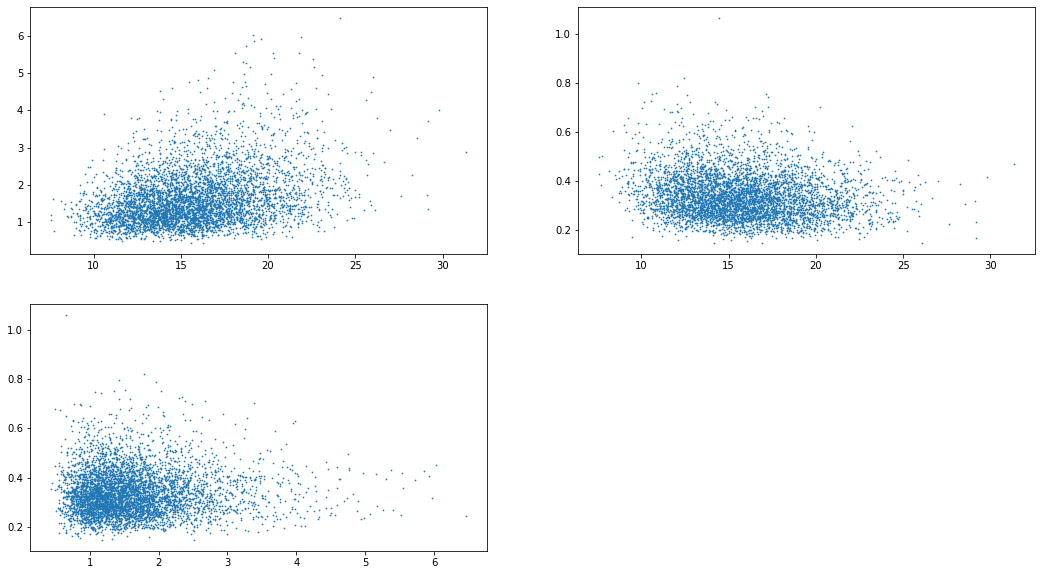

In [207]:
plt.figure(figsize = (18, 10))
plt.subplot(221)
plt.scatter(parameter_samples[0].numpy(), parameter_samples[1].numpy(), 0.5)
plt.subplot(222)
plt.scatter(parameter_samples[0].numpy(), parameter_samples[2].numpy(), 0.5)
plt.subplot(223)
plt.scatter(parameter_samples[1].numpy(), parameter_samples[2].numpy(), 0.5)
plt.show()

Had to play around with the priors and initialisations a lot to avoid the covariance converging to `inf` or `nan`.

In [208]:
f_samples = []

for i in range(num_samples):
    # Note that hmc_helper.current_state contains the unconstrained variables
    for var, var_samples in zip(hmc_helper.current_state, samples):
        var.assign(var_samples[i])
    f_batch = model.predict_f_samples(Xtest, 5)
    f_samples.append(f_batch)
f_samples_marg = np.vstack(f_samples)
np.random.shuffle(f_samples_marg)

In [209]:
f_samples_marg.shape

(25000, 200, 1)

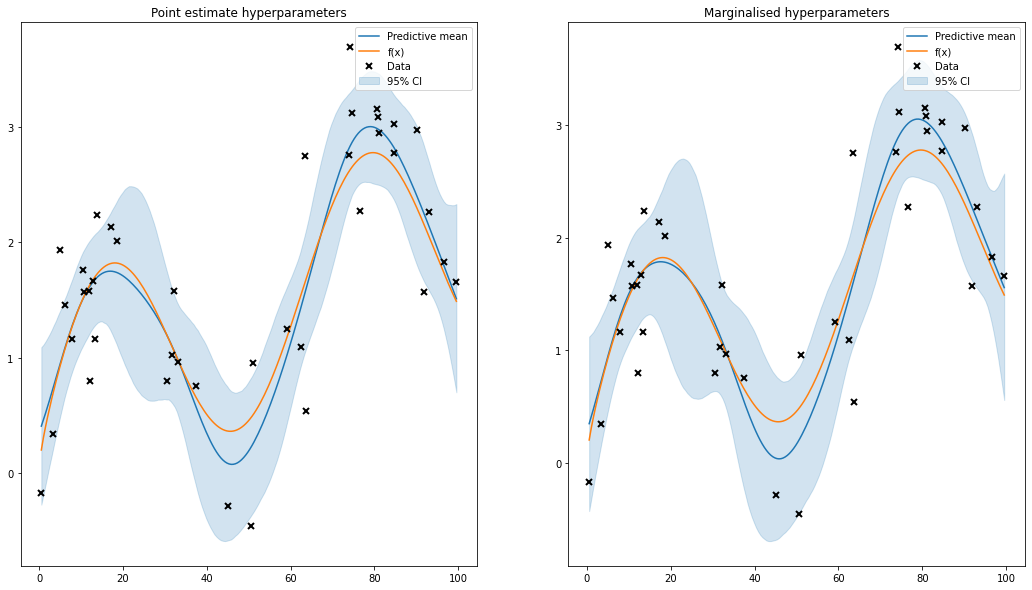

In [214]:
plt.figure(figsize=(18, 10))

plt.subplot(121)
plt.title('Point estimate hyperparameters')
(line_map,) = plt.plot(Xtest, np.mean(f_samples_map, 0), label='Predictive mean')
plt.fill_between(
    Xtest[:, 0],
    np.percentile(np.squeeze(f_samples_map), 2.5, axis=0),
    np.percentile(np.squeeze(f_samples_map), 97.5, axis=0),
    color=line_map.get_color(),
    alpha=0.2,
    label='95% CI'
)
plt.plot(Xtest, f(Xtest), label='f(x)')
plt.plot(X.flatten(), Y.flatten(), "kx", mew=2, label='Data')
plt.legend()

plt.subplot(122)
plt.title('Marginalised hyperparameters')
(line_marg,) = plt.plot(Xtest, np.mean(f_samples_marg, 0), label='Predictive mean')
"""for i in range(25):
    plt.plot(Xtest, f_samples[i, :], 0.01)"""
plt.fill_between(
    Xtest[:, 0],
    np.percentile(np.squeeze(f_samples_marg), 2.5, axis=0),
    np.percentile(np.squeeze(f_samples_marg), 97.5, axis=0),
    color=line_marg.get_color(),
    alpha=0.2,
    label='95% CI'
)
plt.plot(Xtest, f(Xtest), label='f(x)')
plt.plot(X.flatten(), Y.flatten(), "kx", mew=2, label='Data')
plt.legend()

plt.show()

In [211]:
var_diff = np.var(f_samples_marg, 0) - np.var(f_samples_map, 0)

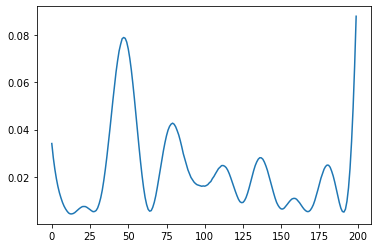

In [212]:
plt.plot(var_diff)

In [213]:
np.mean(var_diff)

0.021936341846298488